Alternative ADALINE neuron, which uses *Stochastic Gradient Descent* (SGD) method of updating weights instead of GD.

Instead of calculating one $\Delta w_j$ for all weights $w_j$, we calculate different $\Delta w_j$ for each $w_j$, following formulas:
$$ \Delta w_j = \eta \left( y^{(i)} - \sigma(z^{(i)}) \right) \cdot x_j^{(i)} $$
$$ \Delta b = \eta \left( y^{(i)} - \sigma(z^{(i)}) \right) $$

Notes:
* SGD is (kinda) an approximation to GD
* SGD is faster than GD since it converges faster, since it updates weights more frequently
* it's better at escaping shallow local minima when working with nonlinear loss functions (since it's more "noisy")
* **always shuffle data**, once in the beginning and later on, periodically (to prevent cycles)
* it works well with *online models*, so in situation when data gets appended live
* often hardcoded $\eta$ is replaced with
$$ \eta = \frac{c_1}{n+c_2} $$
where $n$ - number of iterations

* usage of modified $\eta$ lets us get closer to the global minimum (we will never reach it with this algo)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class AdalineSGD:
  "ADAptive LInear NEuron classifier with Stochastic Gradient Descent"
  def __init__(self, eta=0.01, n_iter=50, shuffle_first=True, seed=1):
    self.eta = eta
    self.n_iter = n_iter
    self.w_initialized = False
    self.shuffle_first = shuffle_first
    self.seed = seed
  def fit(self, x, y):
    self.initialize_weights(x.shape[1])
    self.losses = []

    for i in range(self.n_iter):
      if self.shuffle_first:
        x, y = self.shuffle(x, y)
      losses_epoch = []
      for xi, target in zip(x, y):
        losses_epoch.append(self.update_weights(xi, target))
      avg_loss = np.mean(losses_epoch)
      self.losses.append(avg_loss)
    return self
  def initialize_weights(self, w_len):
    self.rng = np.random.RandomState(self.seed)
    self.w = self.rng.normal(loc=0, scale=0.01, size=w_len)
    self.b = np.float64(0)
    self.w_initialized = True
  def shuffle(self, x, y):
    r = self.rng.permutation(len(y))
    return x[r], y[r]
  def partial_fit(self, x, y):
    """Fit training data without reinitializing the weights,
    can be used manually to update model once more data arrives"""
    if not self.w_initialized:
      self.initialize_weights(x.shape[1])
    if y.ravel().shape[0] > 1:
      for xi, target in zip(x, y):
        self.update_weights(xi, target)
    else:
      self.update_weights(x, y)
    return self
  def update_weights(self, xi, target):
    prediction = self.activation(self.net_input(xi))
    error = (target - prediction)
    self.w += 2*self.eta*error * xi
    self.b += 2*self.eta*error
    loss = error**2
    return loss
  def predict(self, xi):
    return np.where(self.activation(self.net_input(xi)) >= 0.5, 1, 0)
  def net_input(self, xi):
    return xi @ self.w + self.b
  def activation(self, x):
    return x

In [23]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(axes, x, y, classifier, resolution=0.02):
    markers = ('o', 's', '^', 'v', '<')
    colors = ('b', 'r', 'lightgreen', 'gray', 'cyan')
    labels = ('Setosa', 'Virginica')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x0_min, x0_max = x[:, 0].min()-1, x[:, 0].max()+1
    x1_min, x1_max = x[:, 1].min()-1, x[:, 1].max()+1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, resolution), np.arange(x1_min, x1_max, resolution))
    lab = classifier.predict(np.array((xx0.ravel(), xx1.ravel())).T)
    lab = lab.reshape(xx0.shape)

    ax.contourf(xx0, xx1, lab, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx0.min(), xx0.max())
    ax.set_ylim(xx1.min(), xx1.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x[y == cl, 0], x[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=labels[idx], edgecolor='k')
    ax.set_xlabel("Sepal length [standardized]")
    ax.set_ylabel("Petal length [standardized]")
    ax.legend()

In [24]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [25]:
## preprocess data
# should contain 50xIris-setosa and 50xIris-virginica (head it)
y = df.iloc[:100, 4]
# Iris-setosa to 0, Iris-virginica to 1
y = np.where(y == 'Iris-setosa', 0, 1)
# we are interested in sepal length (idx=0) and petal length (idx=1)
x = df.iloc[:100, [0, 2]].values

In [26]:
# standardize input
x_std = np.copy(x)
x_std[:,0] = (x[:,0] - np.mean(x[:,0]))/np.std(x[:,0])
x_std[:,1] = (x[:,1] - np.mean(x[:,1]))/np.std(x[:,1])

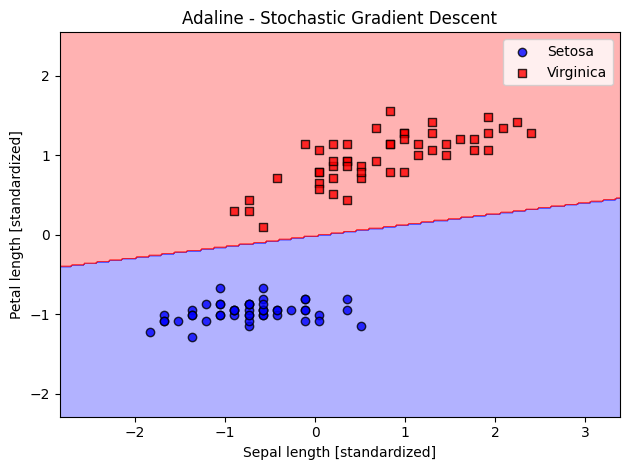

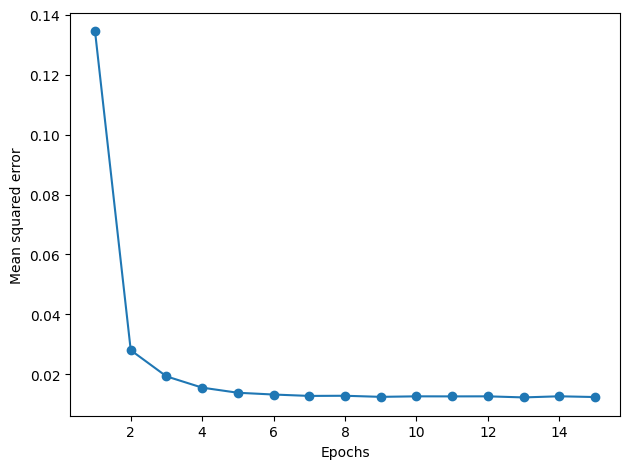

In [ ]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, seed=1).fit(x_std, y)

fig, ax = plt.subplots()
plot_decision_regions(ax, x_std, y, classifier=ada_sgd)
ax.set_title('Adaline - Stochastic Gradient Descent')
fig.set_tight_layout(True)
plt.show()

fig, ax = plt.subplots()
ax.plot(range(1, len(ada_sgd.losses) + 1), ada_sgd.losses, marker='o')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean squared error')
fig.set_tight_layout(True)
plt.show()

# updating our model would look as follows:
# ada_sgd.partial_fit(x_std[0,:], y[0])